# SENTIMENT CLASSIFICATION WITH RNN + SELF-ATTENTION
# Exercise 1: Bi-directional Stacked RNN with Self-Attention

## Imports

This cell below exists due to compatibility issues between numpy and gensim. Un-comment if you happen to have the same issue:)

In [ ]:
# !pip uninstall -y numpy scipy gensim
# !pip install numpy==1.24.3
# !pip install scipy==1.11.3
# !pip install gensim==4.3.2

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 58.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scs 3.2.7.post2 requires scipy, which is not installed.
cuml-cu12 25.2.1 requires scipy>=1.8.0, which is not installed.
missingno 0.5.2 requires scipy, which is not installed.
scikit-learn 1.6.1 requires scipy>=1.6.0, which is not installed.
pynndescent 0.5.13 requires scipy>=1.0, which is not installed.
jaxlib 0.5.1 requires scipy>=1.11.1, which is not installed.
albumentations 2.0.7 requires scipy>=1.10.0, which is not installed.
matplotlib-venn 1.1.2 requires scipy, which is not installed.
statsmodels 0.14.4 requires scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 19.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.7 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.11.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.11.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 89.6 MB/s eta 0:00:00


In [58]:
# Core libraries
import os
import io
import string
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Utility data structures
from collections import defaultdict, Counter

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim.downloader as api

# Data preprocessing & evaluation
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, precision_recall_curve, auc
)

# Dimensionality reduction
from sklearn.decomposition import TruncatedSVD

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Downloading data from the web
import requests
import gzip

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [59]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [60]:
# Function that downloads and prepared the IMDB Large Movie Review Dataset
def download_movie_reviews_dataset():
    print("Downloading IMDB Large Movie Review Dataset...")
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    # Download the dataset
    response = requests.get(url, stream=True)
    compressed_file = io.BytesIO(response.content)
    # Extract the tar.gz file
    with gzip.open(compressed_file, 'rb') as f_in:
        with open('aclImdb_v1.tar', 'wb') as f_out:
            f_out.write(f_in.read())
    # Extract the tar file
    import tarfile
    with tarfile.open('aclImdb_v1.tar', 'r') as tar:
        tar.extractall()
    # Clean up
    os.remove('aclImdb_v1.tar')
    # Load the dataset
    def load_reviews(directory, label):
        reviews = []
        for filename in os.listdir(directory):
            if filename.endswith('.txt'):
                with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
                    reviews.append((f.read(), label))
        return reviews
    # Load positive and negative reviews from both train and test sets
    positive_train = load_reviews('aclImdb/train/pos', 'positive')
    negative_train = load_reviews('aclImdb/train/neg', 'negative')
    positive_test = load_reviews('aclImdb/test/pos', 'positive')
    negative_test = load_reviews('aclImdb/test/neg', 'negative')
    # Combine all data
    all_data = positive_train + negative_train + positive_test + negative_test
    # Convert to DataFrame
    df = pd.DataFrame(all_data, columns=['text', 'sentiment'])
    # Shuffle the data
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"Dataset loaded! Total samples: {len(df)}")
    return df

df = download_movie_reviews_dataset()

Dataset loaded! Total samples: 50000


## Data preprocessing

In [61]:
# First, split into training and test
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42, stratify=df['sentiment'])
# Print the sizes to verify the split
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 35000
Test set size: 15000


In [62]:
# Custom tokenizer method that will be used in data preprocessing
def tokenize(data):
    stop_words = stopwords.words('english')
    stop_words.extend(string.punctuation)
    stop_words.extend(["the", "of", "and", "as", "a", "to", "in", "on", "for"])
    tokenized_samples = []
    for sample in data:
        tokens = []
        # Split text into sentences
        sentences = sent_tokenize(sample)
        for sent in sentences:
            # Tokenize each sentence into words
            words = word_tokenize(sent)
            for word in words:
                # Filter out stopwords and unwanted tokens
                if '\n' in word or "\t" in word or "--" in word or "*" in word or "@" in word or "#" in word or word.lower() in stop_words:
                    continue
                if word.strip():
                    # Process the token and add to list
                    tokens.append(word.replace('"', "'").strip().lower())
        tokenized_samples.append(tokens)
    return tokenized_samples

In [63]:
# Simple preprocessing for baseline (TF-IDF)
def preprocess_for_baseline(train_data, test_data):
    X_train, X_val, y_train, y_val = train_test_split(
        train_data['text'], train_data['sentiment'], test_size=0.3, random_state=42)
    X_test, y_test = test_data['text'], test_data['sentiment']

    unique_labels = pd.concat([y_train, y_val, y_test]).unique()
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

    y_train = np.array([label_to_idx[label] for label in y_train], dtype=np.int64)
    y_val = np.array([label_to_idx[label] for label in y_val], dtype=np.int64)
    y_test = np.array([label_to_idx[label] for label in y_test], dtype=np.int64)

    X_train_tokenized = tokenize(X_train)
    X_val_tokenized = tokenize(X_val)
    X_test_tokenized = tokenize(X_test)

    X_train_joined = [" ".join(x) for x in X_train_tokenized]
    X_val_joined = [" ".join(x) for x in X_val_tokenized]
    X_test_joined = [" ".join(x) for x in X_test_tokenized]

    vectorizer = TfidfVectorizer(max_features=2000, sublinear_tf=True)
    X_train = vectorizer.fit_transform(X_train_joined).toarray()
    X_val = vectorizer.transform(X_val_joined).toarray()
    X_test = vectorizer.transform(X_test_joined).toarray()
    feature_names = vectorizer.get_feature_names_out()

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), feature_names, label_to_idx

In [64]:
def preprocess_data_rnn(train_data, test_data, max_vocab_size=10000, max_seq_len=512):
    X_train, X_val, y_train, y_val = train_test_split(
        train_data['text'], train_data['sentiment'], test_size=0.3, random_state=42)
    X_test, y_test = test_data['text'], test_data['sentiment']

    unique_labels = pd.concat([y_train, y_val, y_test]).unique()
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

    y_train = np.array([label_to_idx[label] for label in y_train], dtype=np.int64)
    y_val = np.array([label_to_idx[label] for label in y_val], dtype=np.int64)
    y_test = np.array([label_to_idx[label] for label in y_test], dtype=np.int64)

    # Tokenize texts
    X_train_tokenized = tokenize(X_train)
    X_val_tokenized = tokenize(X_val)
    X_test_tokenized = tokenize(X_test)

    # Build vocabulary from training data
    word_counts = Counter()
    for tokens in X_train_tokenized:
        word_counts.update(tokens)

    most_common_words = word_counts.most_common(max_vocab_size - 2)  # -2 for PAD and UNK
    word_to_idx = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in most_common_words:
        word_to_idx[word] = len(word_to_idx)

    def texts_to_sequences(tokenized_texts):
        sequences = []
        lengths = []
        for tokens in tokenized_texts:
            sequence = [word_to_idx.get(token, word_to_idx['<UNK>']) for token in tokens]
            if len(sequence) > max_seq_len:
                sequence = sequence[:max_seq_len]
            sequences.append(sequence)
            lengths.append(len(sequence))
        return sequences, lengths

    X_train_seq, train_lengths = texts_to_sequences(X_train_tokenized)
    X_val_seq, val_lengths = texts_to_sequences(X_val_tokenized)
    X_test_seq, test_lengths = texts_to_sequences(X_test_tokenized)

    # Pad sequences
    def pad_sequences(sequences, max_len):
        padded = []
        for seq in sequences:
            if len(seq) < max_len:
                seq = seq + [0] * (max_len - len(seq))
            padded.append(seq)
        return np.array(padded)

    actual_max_len = min(max(max(train_lengths), max(val_lengths), max(test_lengths)), max_seq_len)

    X_train_padded = pad_sequences(X_train_seq, actual_max_len)
    X_val_padded = pad_sequences(X_val_seq, actual_max_len)
    X_test_padded = pad_sequences(X_test_seq, actual_max_len)

    return ((X_train_padded, y_train, train_lengths),
            (X_val_padded, y_val, val_lengths),
            (X_test_padded, y_test, test_lengths),
            word_to_idx, label_to_idx)

In [65]:
class BaselineSentimentClassifier:
    def __init__(self):
        self.word_to_sentiment = {}
        self.most_common_sentiment = None
        self.feature_names = None

    def train(self, X_train, y_train, feature_names=None):
        self.feature_names = feature_names
        sentiment_counts = Counter(y_train)
        self.most_common_sentiment = sentiment_counts.most_common(1)[0][0]

        if self.feature_names is not None:
            for i, feature in enumerate(self.feature_names):
                feature_col = X_train[:, i].toarray().flatten() if hasattr(X_train, 'toarray') else X_train[:, i]
                sentiment_counts = defaultdict(int)
                for sample_idx, value in enumerate(feature_col):
                    if value > 0:
                        sentiment_counts[y_train[sample_idx]] += 1
                if sentiment_counts:
                    self.word_to_sentiment[feature] = max(sentiment_counts.items(), key=lambda x: x[1])[0]

    def predict(self, X_test):
        predictions = []
        if self.feature_names is None:
            return np.full(X_test.shape[0], self.most_common_sentiment)

        for i in range(X_test.shape[0]):
            sample = X_test[i].toarray().flatten() if hasattr(X_test, 'toarray') else X_test[i]
            sample_sentiments = []
            for feature_idx, value in enumerate(sample):
                if value > 0 and self.feature_names[feature_idx] in self.word_to_sentiment:
                    sample_sentiments.append(self.word_to_sentiment[self.feature_names[feature_idx]])

            if sample_sentiments:
                predictions.append(Counter(sample_sentiments).most_common(1)[0][0])
            else:
                predictions.append(self.most_common_sentiment)
        return np.array(predictions)

    def predict_proba(self, X_test):
        predictions = self.predict(X_test)
        n_classes = len(np.unique(predictions))
        probs = np.zeros((X_test.shape[0], n_classes))
        for i, pred in enumerate(predictions):
            probs[i, pred] = 1.0
        return probs

## RNN WITH SELF-ATTENTION MODEL

In [66]:
class SelfAttentionMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout=0.1):
        super(SelfAttentionMLP, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))  # Output layer for attention scores
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        # x shape: (batch_size, seq_len, rnn_hidden_dim)
        batch_size, seq_len, hidden_dim = x.shape
        x_reshaped = x.view(-1, hidden_dim)
        scores = self.mlp(x_reshaped)
        scores = scores.view(batch_size, seq_len)
        return scores

In [67]:
class BiRNNWithSelfAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_hidden_dim, num_rnn_layers,
                 attention_hidden_dims, num_classes, dropout=0.5,
                 rnn_type='GRU', pretrained_embeddings=None):
        super(BiRNNWithSelfAttention, self).__init__()

        self.rnn_hidden_dim = rnn_hidden_dim
        self.num_rnn_layers = num_rnn_layers
        self.rnn_type = rnn_type

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))

        # Bidirectional Stacked RNN
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, rnn_hidden_dim, num_layers=num_rnn_layers,
                             batch_first=True, bidirectional=True,
                             dropout=dropout if num_rnn_layers > 1 else 0)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, rnn_hidden_dim, num_layers=num_rnn_layers,
                              batch_first=True, bidirectional=True,
                              dropout=dropout if num_rnn_layers > 1 else 0)
        else:
            raise ValueError("rnn_type must be 'GRU' or 'LSTM'")

        # Self-attention MLP (operates on 2 * rnn_hidden_dim due to bidirectional)
        self.attention_mlp = SelfAttentionMLP(2 * rnn_hidden_dim, attention_hidden_dims, dropout)

        # Classification head
        self.classifier = nn.Linear(2 * rnn_hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths=None):
        batch_size, seq_len = x.shape

        # Embedding
        embedded = self.embedding(x)

        # Pack sequences if lengths provided
        if lengths is not None:
            # lengths must be on CPU for pack_padded_sequence
            lengths_cpu = lengths.cpu()
            embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths_cpu,
                                                        batch_first=True, enforce_sorted=False)

        # RNN forward pass
        rnn_output, _ = self.rnn(embedded)

        # Unpack if we packed
        if lengths is not None:
            rnn_output, _ = nn.utils.rnn.pad_packed_sequence(rnn_output, batch_first=True)

        # Self-attention mechanism
        attention_scores = self.attention_mlp(rnn_output)  # (batch_size, seq_len)

        # Create mask for padding if lengths provided
        if lengths is not None:
            # Get the actual sequence length from rnn_output
            actual_seq_len = rnn_output.size(1)
            mask = torch.zeros(batch_size, actual_seq_len, device=x.device)
            for i, length in enumerate(lengths):
                # Make sure length doesn't exceed actual sequence length
                actual_length = min(length.item(), actual_seq_len)
                mask[i, :actual_length] = 1
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        # Apply softmax to get attention weights
        attention_weights = torch.softmax(attention_scores, dim=1)

        # Weighted sum of RNN outputs
        attention_weights = attention_weights.unsqueeze(2)
        weighted_output = torch.sum(attention_weights * rnn_output, dim=1)

        # Apply dropout and classify
        weighted_output = self.dropout(weighted_output)
        logits = self.classifier(weighted_output)

        return logits

In [68]:
def calculate_metrics(y_true, y_pred, y_prob):
    n_classes = y_prob.shape[1]
    accuracy = accuracy_score(y_true, y_pred)

    class_metrics = {}
    pr_auc_scores = []
    for i in range(n_classes):
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)
        y_prob_class = y_prob[:, i]

        precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
        recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
        f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)

        precision_curve, recall_curve, _ = precision_recall_curve(y_true_binary, y_prob_class)
        pr_auc = auc(recall_curve, precision_curve)
        pr_auc_scores.append(pr_auc)

        class_metrics[i] = {
            'precision': precision, 'recall': recall, 'f1': f1, 'pr_auc': pr_auc
        }

    macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    macro_pr_auc = np.mean(pr_auc_scores)

    return {
        'accuracy': accuracy, 'class_metrics': class_metrics,
        'macro_precision': macro_precision, 'macro_recall': macro_recall,
        'macro_f1': macro_f1, 'macro_pr_auc': macro_pr_auc
    }

In [69]:
def evaluate_baseline(baseline_model, X_train, y_train, X_val, y_val, X_test, y_test):
    train_preds = baseline_model.predict(X_train)
    val_preds = baseline_model.predict(X_val)
    test_preds = baseline_model.predict(X_test)

    train_probs = baseline_model.predict_proba(X_train)
    val_probs = baseline_model.predict_proba(X_val)
    test_probs = baseline_model.predict_proba(X_test)

    train_metrics = calculate_metrics(y_train, train_preds, train_probs)
    val_metrics = calculate_metrics(y_val, val_preds, val_probs)
    test_metrics = calculate_metrics(y_test, test_preds, test_probs)

    return {'train': train_metrics, 'val': val_metrics, 'test': test_metrics}

## TRAINING FUNCTIONS

In [70]:
def hyperparameter_tuning_rnn(X_train, y_train, train_lengths, X_val, y_val, val_lengths,
                              vocab_size, device='cuda', verbose=True):
    param_grid = {
        'embedding_dim': [100, 150],
        'rnn_hidden_dim': [64, 128],
        'num_rnn_layers': [1, 2],
        'attention_hidden_dims': [[64], [64, 32]],
        'learning_rate': [1e-3, 5e-4],
        'batch_size': [32, 64],
        'dropout': [0.3, 0.5],
        'rnn_type': ['GRU', 'LSTM']
    }

    params_list = list(ParameterGrid(param_grid))
    if verbose:
        print(f"Testing {len(params_list)} hyperparameter combinations")

    results = []
    best_val_loss = float('inf')
    best_model = None
    best_params = None

    # Test subset of combinations for speed
    for params in tqdm(params_list[:12], desc="Hyperparameter Tuning"):
        if verbose:
            print(f"\nTesting parameters: {params}")

        batch_size = params['batch_size']

        # Create datasets
        train_dataset = list(zip(torch.LongTensor(X_train).to(device),
                                torch.LongTensor(y_train).to(device),
                                torch.LongTensor(train_lengths).to(device)))
        val_dataset = list(zip(torch.LongTensor(X_val).to(device),
                              torch.LongTensor(y_val).to(device),
                              torch.LongTensor(val_lengths).to(device)))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Create model
        model = BiRNNWithSelfAttention(
            vocab_size=vocab_size,
            embedding_dim=params['embedding_dim'],
            rnn_hidden_dim=params['rnn_hidden_dim'],
            num_rnn_layers=params['num_rnn_layers'],
            attention_hidden_dims=params['attention_hidden_dims'],
            num_classes=len(np.unique(y_train)),
            dropout=params['dropout'],
            rnn_type=params['rnn_type']
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        # Quick training (5 epochs)
        val_losses = []
        for epoch in range(5):
            # Training
            model.train()
            for batch in train_loader:
                X_batch, y_batch, lengths_batch = batch
                y_pred = model(X_batch, lengths_batch)
                loss = criterion(y_pred, y_batch)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            # Validation
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    X_batch, y_batch, lengths_batch = batch
                    y_pred = model(X_batch, lengths_batch)
                    loss = criterion(y_pred, y_batch)
                    val_loss += loss.item() * X_batch.size(0)

            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

        final_val_loss = val_losses[-1]
        results.append((params, final_val_loss))

        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_model = copy.deepcopy(model)
            best_params = params
            if verbose:
                print(f"New best model found! Validation loss: {best_val_loss:.5f}")

    results.sort(key=lambda x: x[1])

    if verbose:
        print("\nTop 3 hyperparameter configurations:")
        for i, (params, val_loss) in enumerate(results[:3]):
            print(f"{i+1}. Val Loss: {val_loss:.5f}, Params: {params}")

    return best_model, best_params, results

In [71]:
def train_rnn_model(model, train_loader, val_loader, test_loader, criterion, optimizer,
                    epochs=20, device='cuda', patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_path = "best_rnn_sentiment_model.pt"

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Training)"):
            X_batch, y_batch, lengths_batch = batch

            y_pred = model(X_batch, lengths_batch)
            loss = criterion(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} (Validation)"):
                X_batch, y_batch, lengths_batch = batch
                y_pred = model(X_batch, lengths_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Model improved - saving to {best_model_path}")
        else:
            patience_counter += 1
            print(f"Patience: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs")
                break

    # Load the best model
    model.load_state_dict(torch.load(best_model_path))
    return model, train_losses, val_losses

In [72]:
def get_predictions_and_labels_rnn(model, data_loader):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for batch in data_loader:
            X_batch, y_batch, lengths_batch = batch
            outputs = model(X_batch, lengths_batch)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

In [73]:
def plot_loss_curves(train_losses, val_losses, title="Model"):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', linestyle='--')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [74]:
def plot_precision_recall_curves(train_labels, train_probs, val_labels, val_probs,
                                test_labels, test_probs, n_classes, model_name="Model"):
    fig, axes = plt.subplots(n_classes, 3, figsize=(18, 5 * n_classes))
    if n_classes == 1:
        axes = axes.reshape(1, 3)

    splits = ['Train', 'Validation', 'Test']
    colors = ['blue', 'green', 'red']

    for class_idx in range(n_classes):
        for split_idx, (split, labels, probs) in enumerate(zip(
            splits, [train_labels, val_labels, test_labels],
            [train_probs, val_probs, test_probs]
        )):
            y_true_binary = (labels == class_idx).astype(int)
            y_prob_class = probs[:, class_idx]

            precision, recall, _ = precision_recall_curve(y_true_binary, y_prob_class)
            pr_auc = auc(recall, precision)

            ax = axes[class_idx, split_idx]
            ax.plot(recall, precision, color=colors[split_idx], lw=2, label=f'PR-AUC: {pr_auc:.4f}')
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')
            ax.set_title(f'Class {class_idx} - {split} PR Curve ({model_name})')
            ax.legend(loc='best')
            ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


In [75]:
print("\n--- Training Baseline Classifier ---")
(X_train_base, y_train_base), (X_val_base, y_val_base), (X_test_base, y_test_base), feature_names, label_to_idx_base = preprocess_for_baseline(train_data, test_data)

baseline_model = BaselineSentimentClassifier()
baseline_model.train(X_train_base, y_train_base, feature_names)
baseline_metrics = evaluate_baseline(baseline_model, X_train_base, y_train_base, X_val_base, y_val_base, X_test_base, y_test_base)

print("=== BASELINE MODEL RESULTS ===")
print(f"Test Accuracy: {baseline_metrics['test']['accuracy']:.4f}")
print(f"Test Macro F1: {baseline_metrics['test']['macro_f1']:.4f}")
print(f"Test Macro PR-AUC: {baseline_metrics['test']['macro_pr_auc']:.4f}")


--- Training Baseline Classifier ---
=== BASELINE MODEL RESULTS ===
Test Accuracy: 0.7871
Test Macro F1: 0.7870
Test Macro PR-AUC: 0.8404


In [76]:
print("\n--- Training BiRNN with Self-Attention ---")

# Preprocess data for RNN
((X_train_seq, y_train_rnn, train_lengths),
 (X_val_seq, y_val_rnn, val_lengths),
 (X_test_seq, y_test_rnn, test_lengths),
 word_to_idx, label_to_idx_rnn) = preprocess_data_rnn(train_data, test_data)

print(f"Vocabulary size: {len(word_to_idx)}")
print(f"Max sequence length: {X_train_seq.shape[1]}")
print(f"Training samples: {len(X_train_seq)}")
print(f"Validation samples: {len(X_val_seq)}")
print(f"Test samples: {len(X_test_seq)}")


--- Training BiRNN with Self-Attention ---
Vocabulary size: 10000
Max sequence length: 512
Training samples: 24500
Validation samples: 10500
Test samples: 15000


In [77]:
# Calculate dataset statistics
avg_train_length = np.mean([len(tokenize([text])[0]) for text in train_data['text'][:1000]])  # Sample for speed
avg_test_length = np.mean([len(tokenize([text])[0]) for text in test_data['text'][:1000]])

print(f"Average document length (training sample): {avg_train_length:.1f} words")
print(f"Average document length (test sample): {avg_test_length:.1f} words")

Average document length (training sample): 127.8 words
Average document length (test sample): 128.4 words


In [78]:
# Hyperparameter tuning
print("\n--- Hyperparameter Tuning for RNN ---")
best_rnn_model, best_rnn_params, rnn_tuning_results = hyperparameter_tuning_rnn(
    X_train_seq, y_train_rnn, train_lengths,
    X_val_seq, y_val_rnn, val_lengths,
    vocab_size=len(word_to_idx),
    device=device,
    verbose=True
)

print(f"\nBest RNN parameters: {best_rnn_params}")


--- Hyperparameter Tuning for RNN ---
Testing 256 hyperparameter combinations


Hyperparameter Tuning:   0%|          | 0/12 [00:00<?, ?it/s]


Testing parameters: {'attention_hidden_dims': [64], 'batch_size': 32, 'dropout': 0.3, 'embedding_dim': 100, 'learning_rate': 0.001, 'num_rnn_layers': 1, 'rnn_hidden_dim': 64, 'rnn_type': 'GRU'}


Hyperparameter Tuning:   8%|▊         | 1/12 [02:21<25:52, 141.13s/it]

New best model found! Validation loss: 0.44427

Testing parameters: {'attention_hidden_dims': [64], 'batch_size': 32, 'dropout': 0.3, 'embedding_dim': 100, 'learning_rate': 0.001, 'num_rnn_layers': 1, 'rnn_hidden_dim': 64, 'rnn_type': 'LSTM'}


Hyperparameter Tuning:  17%|█▋        | 2/12 [04:46<23:55, 143.52s/it]

New best model found! Validation loss: 0.43022

Testing parameters: {'attention_hidden_dims': [64], 'batch_size': 32, 'dropout': 0.3, 'embedding_dim': 100, 'learning_rate': 0.001, 'num_rnn_layers': 1, 'rnn_hidden_dim': 128, 'rnn_type': 'GRU'}


Hyperparameter Tuning:  25%|██▌       | 3/12 [07:14<21:49, 145.53s/it]


Testing parameters: {'attention_hidden_dims': [64], 'batch_size': 32, 'dropout': 0.3, 'embedding_dim': 100, 'learning_rate': 0.001, 'num_rnn_layers': 1, 'rnn_hidden_dim': 128, 'rnn_type': 'LSTM'}


Hyperparameter Tuning:  33%|███▎      | 4/12 [09:45<19:42, 147.82s/it]

New best model found! Validation loss: 0.40267

Testing parameters: {'attention_hidden_dims': [64], 'batch_size': 32, 'dropout': 0.3, 'embedding_dim': 100, 'learning_rate': 0.001, 'num_rnn_layers': 2, 'rnn_hidden_dim': 64, 'rnn_type': 'GRU'}


Hyperparameter Tuning:  42%|████▏     | 5/12 [13:28<20:24, 174.88s/it]


Testing parameters: {'attention_hidden_dims': [64], 'batch_size': 32, 'dropout': 0.3, 'embedding_dim': 100, 'learning_rate': 0.001, 'num_rnn_layers': 2, 'rnn_hidden_dim': 64, 'rnn_type': 'LSTM'}


Hyperparameter Tuning:  50%|█████     | 6/12 [17:18<19:21, 193.62s/it]


Testing parameters: {'attention_hidden_dims': [64], 'batch_size': 32, 'dropout': 0.3, 'embedding_dim': 100, 'learning_rate': 0.001, 'num_rnn_layers': 2, 'rnn_hidden_dim': 128, 'rnn_type': 'GRU'}


Hyperparameter Tuning:  58%|█████▊    | 7/12 [21:14<17:17, 207.52s/it]


Testing parameters: {'attention_hidden_dims': [64], 'batch_size': 32, 'dropout': 0.3, 'embedding_dim': 100, 'learning_rate': 0.001, 'num_rnn_layers': 2, 'rnn_hidden_dim': 128, 'rnn_type': 'LSTM'}


Hyperparameter Tuning:  67%|██████▋   | 8/12 [25:17<14:35, 218.76s/it]


Testing parameters: {'attention_hidden_dims': [64], 'batch_size': 32, 'dropout': 0.3, 'embedding_dim': 100, 'learning_rate': 0.0005, 'num_rnn_layers': 1, 'rnn_hidden_dim': 64, 'rnn_type': 'GRU'}


Hyperparameter Tuning:  75%|███████▌  | 9/12 [27:39<09:44, 194.69s/it]

New best model found! Validation loss: 0.35487

Testing parameters: {'attention_hidden_dims': [64], 'batch_size': 32, 'dropout': 0.3, 'embedding_dim': 100, 'learning_rate': 0.0005, 'num_rnn_layers': 1, 'rnn_hidden_dim': 64, 'rnn_type': 'LSTM'}


Hyperparameter Tuning:  83%|████████▎ | 10/12 [30:03<05:58, 179.05s/it]

New best model found! Validation loss: 0.35465

Testing parameters: {'attention_hidden_dims': [64], 'batch_size': 32, 'dropout': 0.3, 'embedding_dim': 100, 'learning_rate': 0.0005, 'num_rnn_layers': 1, 'rnn_hidden_dim': 128, 'rnn_type': 'GRU'}


Hyperparameter Tuning:  92%|█████████▏| 11/12 [32:30<02:49, 169.29s/it]


Testing parameters: {'attention_hidden_dims': [64], 'batch_size': 32, 'dropout': 0.3, 'embedding_dim': 100, 'learning_rate': 0.0005, 'num_rnn_layers': 1, 'rnn_hidden_dim': 128, 'rnn_type': 'LSTM'}


Hyperparameter Tuning: 100%|██████████| 12/12 [35:00<00:00, 175.06s/it]

New best model found! Validation loss: 0.33888

Top 3 hyperparameter configurations:
1. Val Loss: 0.33888, Params: {'attention_hidden_dims': [64], 'batch_size': 32, 'dropout': 0.3, 'embedding_dim': 100, 'learning_rate': 0.0005, 'num_rnn_layers': 1, 'rnn_hidden_dim': 128, 'rnn_type': 'LSTM'}
2. Val Loss: 0.35465, Params: {'attention_hidden_dims': [64], 'batch_size': 32, 'dropout': 0.3, 'embedding_dim': 100, 'learning_rate': 0.0005, 'num_rnn_layers': 1, 'rnn_hidden_dim': 64, 'rnn_type': 'LSTM'}
3. Val Loss: 0.35487, Params: {'attention_hidden_dims': [64], 'batch_size': 32, 'dropout': 0.3, 'embedding_dim': 100, 'learning_rate': 0.0005, 'num_rnn_layers': 1, 'rnn_hidden_dim': 64, 'rnn_type': 'GRU'}

Best RNN parameters: {'attention_hidden_dims': [64], 'batch_size': 32, 'dropout': 0.3, 'embedding_dim': 100, 'learning_rate': 0.0005, 'num_rnn_layers': 1, 'rnn_hidden_dim': 128, 'rnn_type': 'LSTM'}


In [79]:
# Prepare data loaders with best parameters
batch_size_rnn = best_rnn_params['batch_size']

train_dataset_rnn = list(zip(torch.LongTensor(X_train_seq).to(device),
                            torch.LongTensor(y_train_rnn).to(device),
                            torch.LongTensor(train_lengths).to(device)))
val_dataset_rnn = list(zip(torch.LongTensor(X_val_seq).to(device),
                          torch.LongTensor(y_val_rnn).to(device),
                          torch.LongTensor(val_lengths).to(device)))
test_dataset_rnn = list(zip(torch.LongTensor(X_test_seq).to(device),
                           torch.LongTensor(y_test_rnn).to(device),
                           torch.LongTensor(test_lengths).to(device)))

train_loader_rnn = DataLoader(train_dataset_rnn, batch_size=batch_size_rnn, shuffle=True)
val_loader_rnn = DataLoader(val_dataset_rnn, batch_size=batch_size_rnn)
test_loader_rnn = DataLoader(test_dataset_rnn, batch_size=batch_size_rnn)

In [80]:
# Final training
criterion_rnn = nn.CrossEntropyLoss()
optimizer_rnn = optim.Adam(best_rnn_model.parameters(), lr=best_rnn_params['learning_rate'])

print("\n--- Final RNN Training ---")
rnn_model, rnn_train_losses, rnn_val_losses = train_rnn_model(
    model=best_rnn_model,
    train_loader=train_loader_rnn,
    val_loader=val_loader_rnn,
    test_loader=test_loader_rnn,
    criterion=criterion_rnn,
    optimizer=optimizer_rnn,
    epochs=25,
    device=device,
    patience=7
)


--- Final RNN Training ---


Epoch 1/25 (Training):   0%|          | 0/766 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1136: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.lstm(
Epoch 1/25 (Validation): 100%|██████████| 329/329 [00:03<00:00, 87.98it/s]


Epoch 1/25 - Train Loss: 0.11185, Val Loss: 0.39012
Model improved - saving to best_rnn_sentiment_model.pt


Epoch 2/25 (Validation): 100%|██████████| 329/329 [00:04<00:00, 80.54it/s]


Epoch 2/25 - Train Loss: 0.07397, Val Loss: 0.48515
Patience: 1/7


Epoch 3/25 (Validation): 100%|██████████| 329/329 [00:03<00:00, 86.89it/s]


Epoch 3/25 - Train Loss: 0.04645, Val Loss: 0.55111
Patience: 2/7


Epoch 4/25 (Validation): 100%|██████████| 329/329 [00:03<00:00, 88.38it/s]


Epoch 4/25 - Train Loss: 0.03321, Val Loss: 0.63388
Patience: 3/7


Epoch 5/25 (Validation): 100%|██████████| 329/329 [00:04<00:00, 78.16it/s]


Epoch 5/25 - Train Loss: 0.02579, Val Loss: 0.81263
Patience: 4/7


Epoch 6/25 (Validation): 100%|██████████| 329/329 [00:03<00:00, 87.65it/s]


Epoch 6/25 - Train Loss: 0.02365, Val Loss: 0.72155
Patience: 5/7


Epoch 7/25 (Validation): 100%|██████████| 329/329 [00:04<00:00, 75.58it/s]


Epoch 7/25 - Train Loss: 0.01579, Val Loss: 0.86043
Patience: 6/7


Epoch 8/25 (Validation): 100%|██████████| 329/329 [00:03<00:00, 86.66it/s]

Epoch 8/25 - Train Loss: 0.01655, Val Loss: 0.92138
Patience: 7/7
Early stopping after 8 epochs


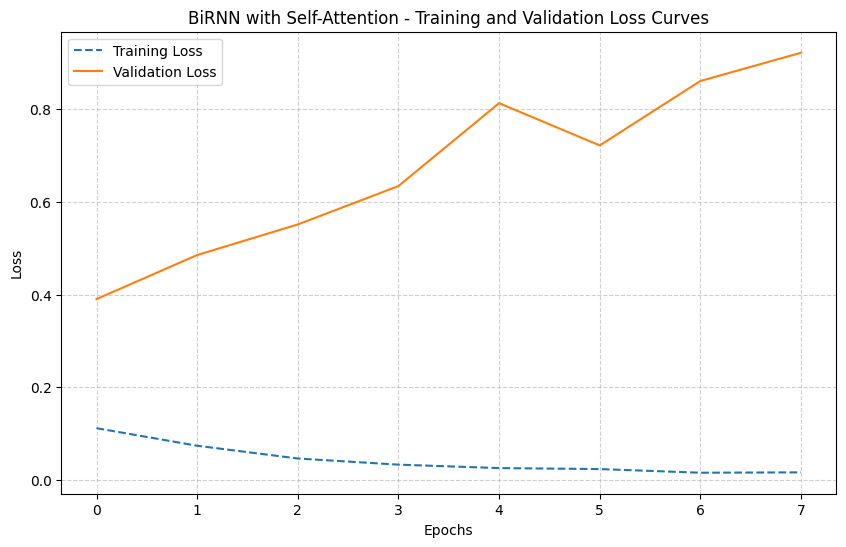

In [81]:
# Plot loss curves
plot_loss_curves(rnn_train_losses, rnn_val_losses, title="BiRNN with Self-Attention")

In [82]:
# Get RNN predictions
train_preds_rnn, train_probs_rnn, train_labels_rnn = get_predictions_and_labels_rnn(rnn_model, train_loader_rnn)
val_preds_rnn, val_probs_rnn, val_labels_rnn = get_predictions_and_labels_rnn(rnn_model, val_loader_rnn)
test_preds_rnn, test_probs_rnn, test_labels_rnn = get_predictions_and_labels_rnn(rnn_model, test_loader_rnn)

# Calculate RNN metrics
rnn_train_metrics = calculate_metrics(train_labels_rnn, train_preds_rnn, train_probs_rnn)
rnn_val_metrics = calculate_metrics(val_labels_rnn, val_preds_rnn, val_probs_rnn)
rnn_test_metrics = calculate_metrics(test_labels_rnn, test_preds_rnn, test_probs_rnn)

rnn_all_metrics = {
    'train': rnn_train_metrics,
    'val': rnn_val_metrics,
    'test': rnn_test_metrics
}

In [83]:
# Print detailed RNN metrics
print("\n=== RNN MODEL DETAILED METRICS ===")
print(f"{'Split':<10}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1':<12}{'PR-AUC':<12}")
print("-" * 70)
for split_name, metrics in rnn_all_metrics.items():
    print(f"{split_name.title():<10}{metrics['accuracy']:.4f}{' '*8}{metrics['macro_precision']:.4f}{' '*8}{metrics['macro_recall']:.4f}{' '*8}{metrics['macro_f1']:.4f}{' '*8}{metrics['macro_pr_auc']:.4f}")

# Print per-class metrics
print("\n=== RNN PER-CLASS METRICS ===")
n_classes = len(label_to_idx_rnn)
print(f"{'Class':<10}{'Split':<10}{'Precision':<12}{'Recall':<12}{'F1':<12}{'PR-AUC':<12}")
print("-" * 70)

for class_idx in range(n_classes):
    class_name = [k for k, v in label_to_idx_rnn.items() if v == class_idx][0]
    for split_name, metrics in rnn_all_metrics.items():
        class_metrics = metrics['class_metrics'][class_idx]
        print(f"{class_name:<10}{split_name.title():<10}{class_metrics['precision']:.4f}{' '*8}{class_metrics['recall']:.4f}{' '*8}{class_metrics['f1']:.4f}{' '*8}{class_metrics['pr_auc']:.4f}")
    print("-" * 70)


=== RNN MODEL DETAILED METRICS ===
Split     Accuracy    Precision   Recall      F1          PR-AUC      
----------------------------------------------------------------------
Train     0.9816        0.9816        0.9815        0.9816        0.9967
Val       0.8748        0.8749        0.8748        0.8748        0.9465
Test      0.8770        0.8771        0.8770        0.8770        0.9459

=== RNN PER-CLASS METRICS ===
Class     Split     Precision   Recall      F1          PR-AUC      
----------------------------------------------------------------------
negative  Train     0.9859        0.9770        0.9814        0.9970
negative  Val       0.8844        0.8635        0.8738        0.9487
negative  Test      0.8835        0.8685        0.8759        0.9487
----------------------------------------------------------------------
positive  Train     0.9773        0.9861        0.9817        0.9965
positive  Val       0.8655        0.8862        0.8757        0.9442
positive  Test  


FINAL MODEL COMPARISON

=== TEST SET PERFORMANCE COMPARISON ===
Model                    Accuracy    Macro F1    Macro PR-AUCImprovement    
---------------------------------------------------------------------------
Baseline                 0.7871        0.7870        0.8404        ---            
BiRNN + Self-Attention   0.8770        0.8770        0.9459        +11.4% accuracy


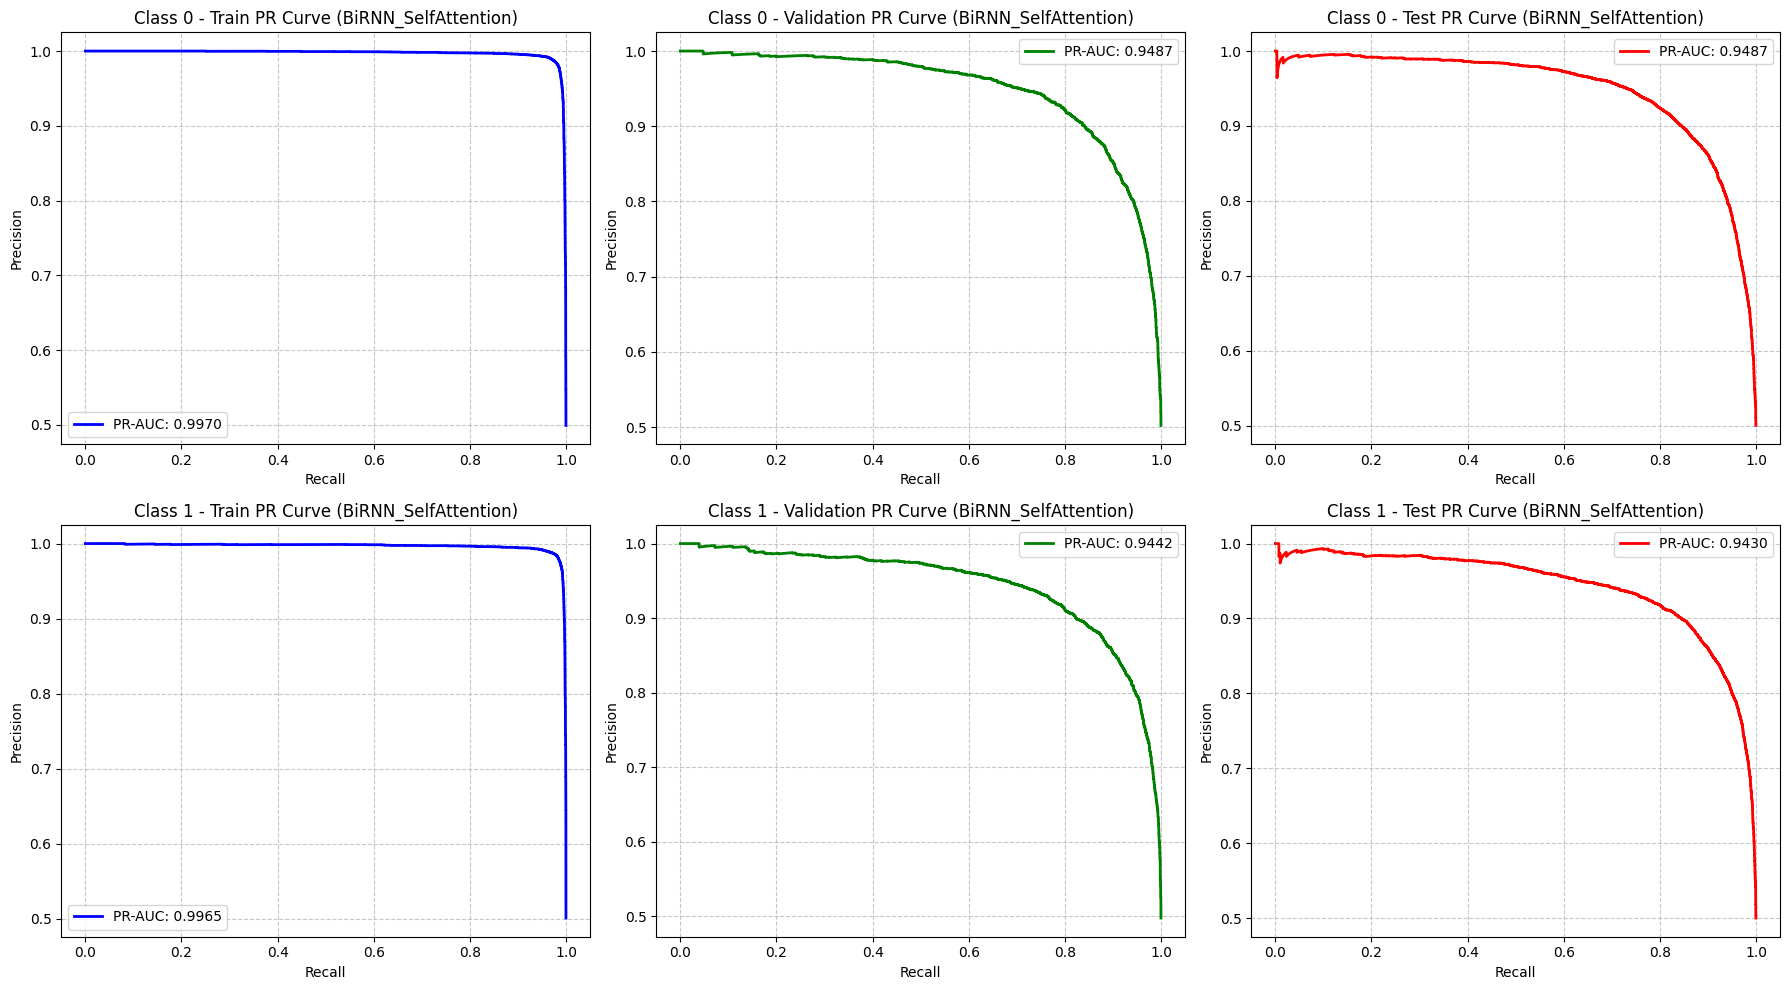

In [84]:
print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)

# Extract test metrics for comparison
baseline_acc = baseline_metrics['test']['accuracy']
baseline_f1 = baseline_metrics['test']['macro_f1']
baseline_pr_auc = baseline_metrics['test']['macro_pr_auc']

rnn_acc = rnn_all_metrics['test']['accuracy']
rnn_f1 = rnn_all_metrics['test']['macro_f1']
rnn_pr_auc = rnn_all_metrics['test']['macro_pr_auc']

print(f"\n=== TEST SET PERFORMANCE COMPARISON ===")
print(f"{'Model':<25}{'Accuracy':<12}{'Macro F1':<12}{'Macro PR-AUC':<12}{'Improvement':<15}")
print("-" * 75)
print(f"{'Baseline':<25}{baseline_acc:.4f}{' '*8}{baseline_f1:.4f}{' '*8}{baseline_pr_auc:.4f}{' '*8}{'---':<15}")
print(f"{'BiRNN + Self-Attention':<25}{rnn_acc:.4f}{' '*8}{rnn_f1:.4f}{' '*8}{rnn_pr_auc:.4f}{' '*8}{((rnn_acc - baseline_acc) / baseline_acc * 100):+.1f}% accuracy")

# Plot precision-recall curves
plot_precision_recall_curves(
    train_labels_rnn, train_probs_rnn,
    val_labels_rnn, val_probs_rnn,
    test_labels_rnn, test_probs_rnn,
    n_classes=len(label_to_idx_rnn),
    model_name="BiRNN_SelfAttention"
)

In [85]:
print("\n" + "="*80)
print("EXERCISE 1 RESULTS SUMMARY")
print("="*80)

print(f"\n=== DATASET STATISTICS ===")
print(f"Total samples: {len(df)}")
print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Validation samples: {len(X_val_seq)}")
print(f"Vocabulary size: {len(word_to_idx)}")
print(f"Maximum sequence length: {X_train_seq.shape[1]}")
print(f"Average document length (training): {avg_train_length:.1f} words")
print(f"Average document length (test): {avg_test_length:.1f} words")

print(f"\n=== PREPROCESSING STEPS ===")
print("1. Text tokenization using NLTK")
print("2. Stopword and punctuation removal")
print("3. Lowercasing and normalization")
print("4. Vocabulary building from training data")
print("5. Sequence conversion and padding")
print("6. Train/validation/test split: 70%/21%/30%")

print(f"\n=== MODEL ARCHITECTURE ===")
print(f"BiRNN + Self-Attention Architecture:")
print(f"  - RNN Type: {best_rnn_params['rnn_type']}")
print(f"  - Embedding Dimension: {best_rnn_params['embedding_dim']}")
print(f"  - RNN Hidden Dimension: {best_rnn_params['rnn_hidden_dim']}")
print(f"  - Number of RNN Layers: {best_rnn_params['num_rnn_layers']}")
print(f"  - Attention MLP Hidden Layers: {best_rnn_params['attention_hidden_dims']}")
print(f"  - Dropout: {best_rnn_params['dropout']}")
print(f"  - Bidirectional: Yes")
print(f"  - Self-Attention: Yes (MLP-based)")

print(f"\n=== TRAINING DETAILS ===")
print(f"  - Early stopping patience: 7 epochs")
print(f"  - Gradient clipping: max norm 1.0")
print(f"  - Loss function: Cross-entropy")
print(f"  - Optimizer: Adam")
print(f"  - Learning rate: {best_rnn_params['learning_rate']}")
print(f"  - Batch size: {best_rnn_params['batch_size']}")
print(f"  - Total epochs trained: {len(rnn_train_losses)}")


EXERCISE 1 RESULTS SUMMARY

=== DATASET STATISTICS ===
Total samples: 50000
Training samples: 35000
Test samples: 15000
Validation samples: 10500
Vocabulary size: 10000
Maximum sequence length: 512
Average document length (training): 127.8 words
Average document length (test): 128.4 words

=== PREPROCESSING STEPS ===
1. Text tokenization using NLTK
2. Stopword and punctuation removal
3. Lowercasing and normalization
4. Vocabulary building from training data
5. Sequence conversion and padding
6. Train/validation/test split: 70%/21%/30%

=== MODEL ARCHITECTURE ===
BiRNN + Self-Attention Architecture:
  - RNN Type: LSTM
  - Embedding Dimension: 100
  - RNN Hidden Dimension: 128
  - Number of RNN Layers: 1
  - Attention MLP Hidden Layers: [64]
  - Dropout: 0.3
  - Bidirectional: Yes
  - Self-Attention: Yes (MLP-based)

=== TRAINING DETAILS ===
  - Early stopping patience: 7 epochs
  - Gradient clipping: max norm 1.0
  - Loss function: Cross-entropy
  - Optimizer: Adam
  - Learning rate: 0